<a href="https://colab.research.google.com/github/sandhrabijoy/Hand-Gesture-Recognition-Rock-Paper-Scissors/blob/main/MICROPROJECT_FINALipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DATA EXPLORATION


In [ ]:
!pip install scikit-plot
from scikitplot.estimators import plot_feature_importances
from scikitplot.metrics import plot_confusion_matrix, plot_roc

In [ ]:
#Importing the basic librarires
import math
import scipy
import numpy as np
import pandas as pd
from sklearn import tree
from scipy.stats import randint
from scipy.stats import loguniform
from IPython.display import display

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from scikitplot.metrics import plot_roc_curve as auc_roc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, \
f1_score, roc_auc_score, roc_curve, precision_score, recall_score

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing the dataset

df = pd.read_csv('/content/drive/MyDrive/Titanic-Dataset.csv.xls')
df.drop(['PassengerId','Name','Ticket','Cabin'],axis=1, inplace=True)

target = 'Survived'
labels = ['Not-Survived','Survived']
features = [i for i in df.columns.values if i not in [target]]

original_df = df.copy(deep=True)
display(df.head())

print('n\033[1m\Inference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


n\Inference: The Datset consists of 8 features & 891 samples.


In [ ]:
#Checking the dtypes of all the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [ ]:
df.nunique().sort_values()

Survived      2
Sex           2
Pclass        3
Embarked      3
SibSp         7
Parch         7
Age          88
Fare        248
dtype: int64

In [ ]:
#Checking number of unique rows in each feature

nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=15:cf.append(nu.index[i])
    else: nf.append(nu.index[i])


print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 2 numerical & 5 categorical features.


In [ ]:
#Checking the stats of all the columns

display(df.describe())

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


DATA PREPROCESSING

In [ ]:
counter = 0
r,c = df.shape

df1 = df.copy()
df1.drop_duplicates(inplace=True)
df1.reset_index(drop=True,inplace=True)

if df1.shape==(r,c):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped ---> {r-df1.shape[0]}')


Inference: Number of duplicates dropped ---> 111


In [ ]:
#Check for empty elements

nvc = pd.DataFrame(df1.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df1.shape[0],3)*100
print(nvc)

          Total Null Values  Percentage
Survived                  0         0.0
Pclass                    0         0.0
Sex                       0         0.0
SibSp                     0         0.0
Parch                     0         0.0
Fare                      0         0.0
Embarked                  2         0.3
Age                     104        13.3


In [ ]:
#Converting categorical Columns to Numeric

#df1 = df.copy()
ecc = nvc[nvc['Percentage']!=0].index.values
dcc = [i for i in df.columns if i not in ecc]

#Target Variable
MAP={}
for i,e in enumerate(df1[target].unique()):
    MAP[e]=i
df1[target]=df1[target].map(MAP)
print('Mapping Target variable --->',MAP)

df3 = df1[dcc]
fcc = [i for i in cf if i not in ecc]

#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1m\nOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)

df3.shape

Mapping Target variable ---> {0: 0, 1: 1}

One-Hot Encoding on features:
Sex

Dummy Encoding on features:
Pclass
SibSp
Parch


(780, 17)

In [ ]:
# Fixing Empty Numerical Columns

for x in [i for i in ecc if i not in cf]:
    a = df1[x]
    b=[]; c=[]

    for i,e in enumerate(a):
        if e!=e:
            b.append(i)
        else:
            c.append(i)

    LR = LinearRegression()
    LR.fit(df3.loc[c],a[c])
    d = LR.predict(df3.loc[b])

    df3[x] = a
    f=0
    for i,e in enumerate(df3[x]):
        if e!=e:
            df3.loc[i,x] = d[f]
            f+=1
    #df3 = pd.concat([df3.drop([x], axis=1), pd.DataFrame(pd.get_dummies(df3[x], drop_first=True, prefix=str(x)))],axis=1)
df3

,Survived,Sex,Fare,Pclass_2,Pclass_3,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Age
0,0,True,7.2500,False,True,True,False,False,False,False,False,False,False,False,False,False,False,22.000000
1,1,False,71.2833,False,False,True,False,False,False,False,False,False,False,False,False,False,False,38.000000
2,1,False,7.9250,False,True,False,False,False,False,False,False,False,False,False,False,False,False,26.000000
3,1,False,53.1000,False,False,True,False,False,False,False,False,False,False,False,False,False,False,35.000000
4,0,True,8.0500,False,True,False,False,False,False,False,False,False,False,False,False,False,False,35.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,0,False,29.1250,False,True,False,False,False,False,False,False,False,False,False,False,True,False,39.000000
776,1,False,30.0000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,19.000000
777,0,False,23.4500,False,True,True,False,False,False,False,False,False,True,False,False,False,False,17.167227
778,1,True,30.0000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,26.000000


In [ ]:
#Removal of outlier:

df4 = df3.copy()

for i in [i for i in df4.columns]:
    if df4[i].nunique()>=12:
        Q1 = df4[i].quantile(0.20)
        Q3 = df4[i].quantile(0.80)
        IQR = Q3 - Q1
        df4 = df4[df4[i] <= (Q3+(1.5*IQR))]
        df4 = df4[df4[i] >= (Q1-(1.5*IQR))]
df4 = df4.reset_index(drop=True)
display(df4.head())
print('\n\033[1mInference:\033[0m Before removal of outliers, The dataset had {} samples.'.format(df1.shape[0]))
print('\033[1mInference:\033[0m After removal of outliers, The dataset now has {} samples.'.format(df4.shape[0]))

,Survived,Sex,Fare,Pclass_2,Pclass_3,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Age
0,0,True,7.2500,False,True,True,False,False,False,False,False,False,False,False,False,False,False,22.0
1,1,False,71.2833,False,False,True,False,False,False,False,False,False,False,False,False,False,False,38.0
2,1,False,7.9250,False,True,False,False,False,False,False,False,False,False,False,False,False,False,26.0
3,1,False,53.1000,False,False,True,False,False,False,False,False,False,False,False,False,False,False,35.0
4,0,True,8.0500,False,True,False,False,False,False,False,False,False,False,False,False,False,False,35.0



Inference: Before removal of outliers, The dataset had 780 samples.
Inference: After removal of outliers, The dataset now has 727 samples.


In [ ]:
#Fixing the imbalance using SMOTE Technique

df5 = df4.copy()

print('Original class distribution:')
print(df5[target].value_counts())

xf = df5.columns
X = df5.drop([target],axis=1)
Y = df5[target]

smote = SMOTE()
X, Y = smote.fit_resample(X, Y)

df5 = pd.DataFrame(X, columns=xf)
df5[target] = Y

print('\nClass distribution after applying SMOTE Technique:',)
print(Y.value_counts())

Original class distribution:
Survived
0    444
1    283
Name: count, dtype: int64

Class distribution after applying SMOTE Technique:
Survived
0    444
1    444
Name: count, dtype: int64


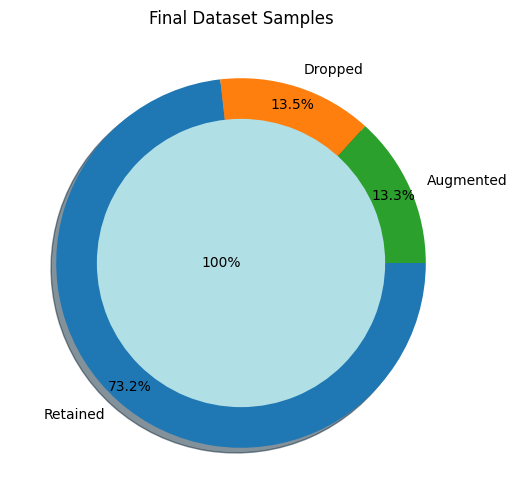


Inference:The final dataset after cleanup has 888 samples & 18 columns.


In [ ]:
#Final Dataset size after performing Preprocessing

df = df5.copy()
plt.title('Final Dataset Samples')
plt.pie([df.shape[0], original_df.shape[0]-df4.shape[0], df5.shape[0]-df4.shape[0]], radius = 1, shadow=True,
        labels=['Retained','Dropped','Augmented'], counterclock=False, autopct='%1.1f%%', pctdistance=0.9, explode=[0,0,0])
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78, shadow=True, colors=['powderblue'])
plt.show()

print('\n\033[1mInference:\033[0mThe final dataset after cleanup has {} samples & {} columns.'.format(df.shape[0], df.shape[1]))

DATA MANIPULATION

In [ ]:
#Splitting the data intro training & testing sets

df = df5.copy()

X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (888, 17) (888,) 
Training set  --->  (710, 17) (710,) 
Testing set   --->  (178, 17)  (178,)


In [ ]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(100))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(100))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                               Standardardization on Training set                               


,Sex,Fare,Pclass_2,Pclass_3,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Age
count,7.100000e+02,7.100000e+02,7.100000e+02,7.100000e+02,7.100000e+02,7.100000e+02,7.100000e+02,7.100000e+02,7.100000e+02,7.100000e+02,7.100000e+02,7.100000e+02,7.100000e+02,7.100000e+02,7.100000e+02,7.100000e+02,7.100000e+02
mean,-1.007019e-16,2.151643e-16,1.501147e-17,9.757453e-17,-3.002293e-17,1.250956e-17,-2.126624e-17,-2.501911e-18,-1.501147e-17,2.001529e-17,-2.752102e-17,6.254778e-17,5.504204e-17,-2.501911e-17,-4.003058e-17,1.751338e-17,3.264994e-16
std,1.000705e+00,1.000705e+00,1.000705e+00,1.000705e+00,1.000705e+00,1.000705e+00,1.000705e+00,1.000705e+00,1.000705e+00,1.000705e+00,1.000705e+00,1.000705e+00,1.000705e+00,1.000705e+00,1.000705e+00,1.000705e+00,1.000705e+00
min,-1.295857e+00,-1.116138e+00,-5.892780e-01,-1.073087e+00,-6.327673e-01,-2.026221e-01,-1.254463e-01,-1.518379e-01,-8.421519e-02,-5.314940e-02,-4.350629e-01,-3.227988e-01,-9.231862e-02,-6.514047e-02,-8.421519e-02,-3.755579e-02,-2.152549e+00
25%,-1.295857e+00,-7.649562e-01,-5.892780e-01,-1.073087e+00,-6.327673e-01,-2.026221e-01,-1.254463e-01,-1.518379e-01,-8.421519e-02,-5.314940e-02,-4.350629e-01,-3.227988e-01,-9.231862e-02,-6.514047e-02,-8.421519e-02,-3.755579e-02,-6.206201e-01
50%,7.716901e-01,-4.246808e-01,-5.892780e-01,9.318911e-01,-6.327673e-01,-2.026221e-01,-1.254463e-01,-1.518379e-01,-8.421519e-02,-5.314940e-02,-4.350629e-01,-3.227988e-01,-9.231862e-02,-6.514047e-02,-8.421519e-02,-3.755579e-02,-6.145294e-02
75%,7.716901e-01,2.226317e-01,1.696992e+00,9.318911e-01,1.580360e+00,-2.026221e-01,-1.254463e-01,-1.518379e-01,-8.421519e-02,-5.314940e-02,-4.350629e-01,-3.227988e-01,-9.231862e-02,-6.514047e-02,-8.421519e-02,-3.755579e-02,5.451013e-01
max,7.716901e-01,3.526658e+00,1.696992e+00,9.318911e-01,1.580360e+00,4.935296e+00,7.971540e+00,6.585970e+00,1.187434e+01,1.881489e+01,2.298518e+00,3.097905e+00,1.083205e+01,1.535144e+01,1.187434e+01,2.662705e+01,3.198776e+00



                                Standardardization on Testing set                                


,Sex,Fare,Pclass_2,Pclass_3,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Age
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,1.780000e+02,1.780000e+02,178.000000,178.000000,178.000000,1.780000e+02,178.000000,1.780000e+02,178.000000
mean,-0.029775,-0.072776,-0.049821,0.008250,0.038631,-0.087163,0.011020,0.037426,-8.421519e-02,-5.314940e-02,0.102439,-0.053755,-0.030946,-6.514047e-02,-0.017032,-3.755579e-02,0.177543
std,1.010175,0.957222,0.973475,1.002203,1.020275,0.763651,1.045217,1.116426,1.391694e-17,6.958468e-18,1.089525,0.923432,0.818816,1.391694e-17,0.896332,6.958468e-18,1.164579
min,-1.295857,-1.116138,-0.589278,-1.073087,-0.632767,-0.202622,-0.125446,-0.151838,-8.421519e-02,-5.314940e-02,-0.435063,-0.322799,-0.092319,-6.514047e-02,-0.084215,-3.755579e-02,-2.150318
25%,-1.295857,-0.770409,-0.589278,-1.073087,-0.632767,-0.202622,-0.125446,-0.151838,-8.421519e-02,-5.314940e-02,-0.435063,-0.322799,-0.092319,-6.514047e-02,-0.084215,-3.755579e-02,-0.516369
50%,0.771690,-0.507568,-0.589278,0.931891,-0.632767,-0.202622,-0.125446,-0.151838,-8.421519e-02,-5.314940e-02,-0.435063,-0.322799,-0.092319,-6.514047e-02,-0.084215,-3.755579e-02,0.066560
75%,0.771690,0.154442,-0.589278,0.931891,1.580360,-0.202622,-0.125446,-0.151838,-8.421519e-02,-5.314940e-02,-0.435063,-0.322799,-0.092319,-6.514047e-02,-0.084215,-3.755579e-02,1.000017
max,0.771690,2.896799,1.696992,0.931891,1.580360,4.935296,7.971540,6.585970,-8.421519e-02,-5.314940e-02,2.298518,3.097905,10.832051,-6.514047e-02,11.874342,-3.755579e-02,3.198776


PREDICTIVE MODELLING


In [ ]:
#Let us create first create a table to store the results of various models

Evaluation_Results = pd.DataFrame(np.zeros((2,5)), columns=['Accuracy', 'Precision','Recall','F1-score','AUC-ROC score'])
Evaluation_Results.index=['Decision Tree Classifier (DT)','Naïve Bayes Classifier (NB)']

In [ ]:
#Let us define functions to summarise the Prediction's scores .
#Classification Summary Function

def Classification_Summary(pred,pred_prob,i):
    Evaluation_Results.iloc[i]['Accuracy']=round(accuracy_score(Test_Y, pred),3)*100
    Evaluation_Results.iloc[i]['Precision']=round(precision_score(Test_Y, pred, average='weighted'),3)*100
    Evaluation_Results.iloc[i]['Recall']=round(recall_score(Test_Y, pred, average='weighted'),3)*100
    Evaluation_Results.iloc[i]['F1-score']=round(f1_score(Test_Y, pred, average='weighted'),3)*100
    Evaluation_Results.iloc[i]['AUC-ROC score']=round(roc_auc_score(Test_Y, pred_prob[:,1], multi_class='ovr'),3)*100 #[:, 1]
    print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*3,'-'*35,Evaluation_Results.index[i], '-'*35,'>'*3))
    print('Accuracy = {}%'.format(round(accuracy_score(Test_Y, pred),3)*100))
    print('F1 Score = {}%'.format(round(f1_score(Test_Y, pred, average='weighted'),3)*100))
    print('\n \033[1mConfusion Matrix:\033[0m\n',confusion_matrix(Test_Y, pred))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(Test_Y, pred))

    auc_roc(Test_Y, pred_prob, curves=['each_class'])
    plt.show()

#Visualising Function
def AUC_ROC_plot(Test_Y, pred):
    ref = [0 for _ in range(len(Test_Y))]
    ref_auc = roc_auc_score(Test_Y, ref)
    lr_auc = roc_auc_score(Test_Y, pred)

    ns_fpr, ns_tpr, _ = roc_curve(Test_Y, ref)
    lr_fpr, lr_tpr, _ = roc_curve(Test_Y, pred)

    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='AUC = {}'.format(round(roc_auc_score(Test_Y, pred)*100,2)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

NAIVE BAYES CLASSIFIER


<<<----------------------------------- Evaluating Naïve Bayes Classifier (NB) ----------------------------------->>>

Accuracy = 66.9%
F1 Score = 66.7%

 Confusion Matrix:
 [[69 25]
 [34 50]]

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.73      0.70        94
           1       0.67      0.60      0.63        84

    accuracy                           0.67       178
   macro avg       0.67      0.66      0.66       178
weighted avg       0.67      0.67      0.67       178



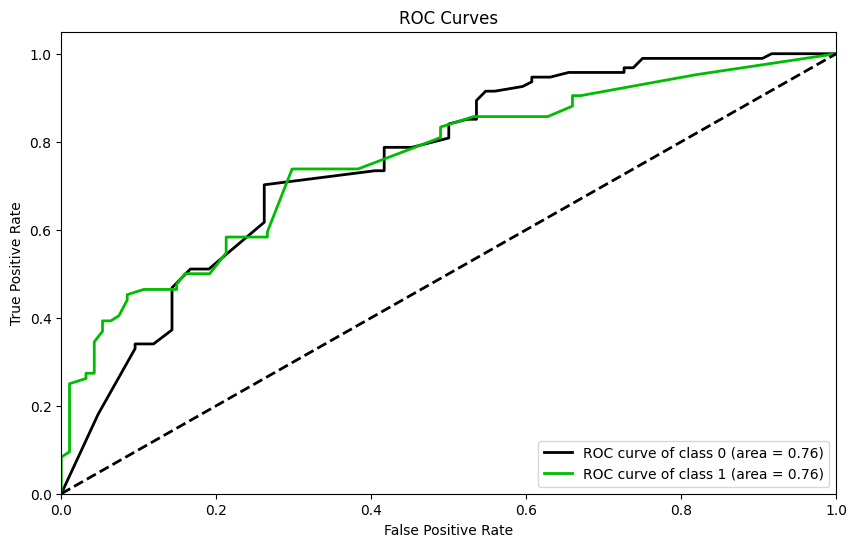

In [ ]:
# Building Naive Bayes Classifier

NB_model = BernoulliNB()

params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(NB_model, params, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

NB = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = NB.predict(Test_X_std)
pred_prob = NB.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,1)

DECISION TREE CLASSIFIER


<<<----------------------------------- Evaluating Decision Tree Classifier (DT) ----------------------------------->>>

Accuracy = 74.2%
F1 Score = 73.8%

 Confusion Matrix:
 [[79 15]
 [31 53]]

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.84      0.77        94
           1       0.78      0.63      0.70        84

    accuracy                           0.74       178
   macro avg       0.75      0.74      0.74       178
weighted avg       0.75      0.74      0.74       178



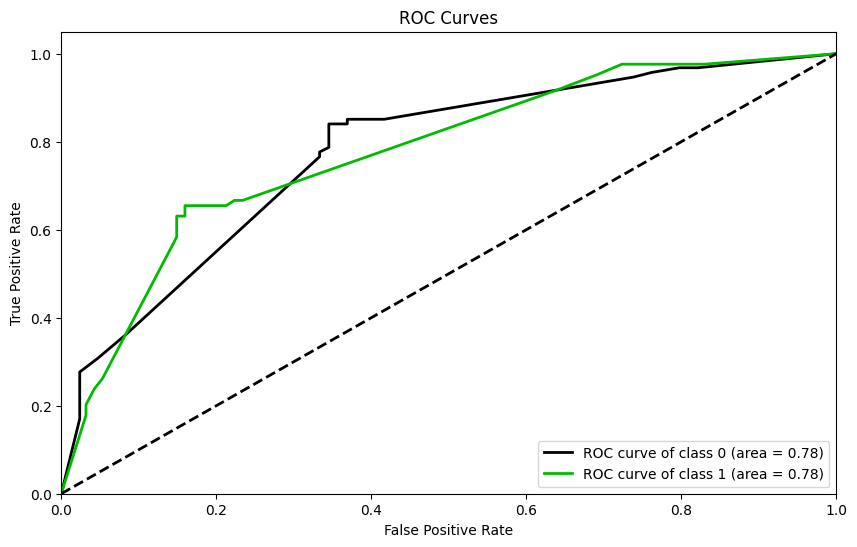


Interpreting the output of Decision Tree:



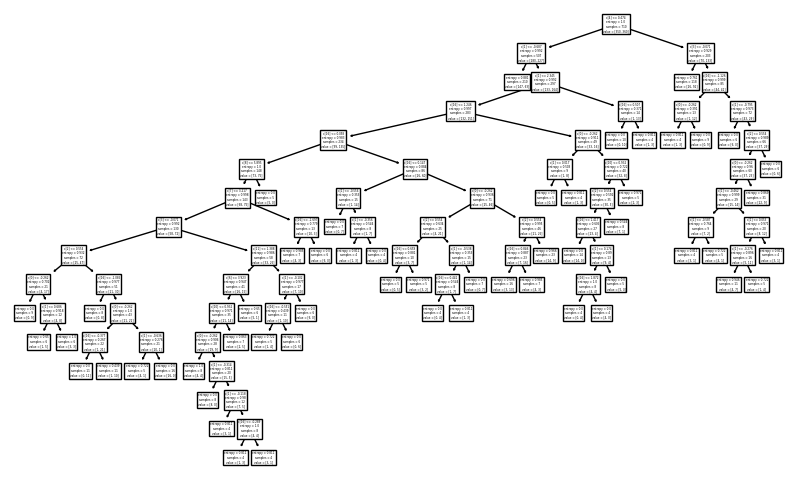

In [ ]:
#Building Decision Tree Classifier

DT_model = DecisionTreeClassifier()

param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(DT_model, param_dist, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

DT = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = DT.predict(Test_X_std)
pred_prob = DT.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,0)

print('\n\033[1mInterpreting the output of Decision Tree:\n\033[0m')
tree.plot_tree(DT)
plt.show()